Basing on the last part, here part 2 I will try to predict the price basing on factors found in last part. And also add other factors to help predict the price.

In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
# load the data
df_listings = pd.read_csv('data/listings.csv')

In [3]:
# clean data
def remove_symbol(price):
    # remove the symbols '$' and ',' in price
    if type(price) is str:
        return re.sub("[\$,]",'',price)
    return price

df_listings.fillna(0, inplace=True)
df_listings['price'] = df_listings.price.apply(remove_symbol)
df_listings['price'] = df_listings['price'].astype(float)

df_listings['extra_people'] = df_listings.extra_people.apply(remove_symbol)
df_listings['extra_people'] = df_listings['extra_people'].astype(float)

In [4]:
# remove invalid rows
df_listings = df_listings[df_listings.room_type != 0]
df_listings = df_listings[df_listings.property_type != 0]
df_listings = df_listings[df_listings.neighbourhood_cleansed != 0]
df_listings = df_listings[df_listings.price > 0]
df_listings = df_listings[df_listings.bathrooms > 0]
df_listings = df_listings[df_listings.bedrooms > 0]
df_listings = df_listings[df_listings.beds > 0]
df_listings = df_listings[df_listings.review_scores_rating > 0]
df_listings = df_listings[df_listings.reviews_per_month > 0]
df_listings = df_listings[df_listings.accommodates > 0]

In [5]:
# replace some string type to int type group by their categories
def replace_to_category(df, name, num = 1):
    column = df[name]
    new_col = []
    category = {}
    for e in column:
        if e in category.keys():
            new_col.append(category[e])
        else:
            category[e] = num
            num += 1
            new_col.append(category[e])
    df[name] = new_col
    return df

df_listings = replace_to_category(df_listings, 'room_type')
df_listings = replace_to_category(df_listings, 'property_type')
df_listings = replace_to_category(df_listings, 'neighbourhood_cleansed')
df_listings = replace_to_category(df_listings, 'instant_bookable', 0)

In [6]:
# select the factors that will be used in the prediction model
df_new = df_listings[['id','neighbourhood_cleansed','property_type','room_type','bedrooms','accommodates','bathrooms','beds','price','extra_people','minimum_nights','review_scores_rating','instant_bookable']]
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2843 entries, 0 to 3814
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2843 non-null   int64  
 1   neighbourhood_cleansed  2843 non-null   int64  
 2   property_type           2843 non-null   int64  
 3   room_type               2843 non-null   int64  
 4   bedrooms                2843 non-null   float64
 5   accommodates            2843 non-null   int64  
 6   bathrooms               2843 non-null   float64
 7   beds                    2843 non-null   float64
 8   price                   2843 non-null   float64
 9   extra_people            2843 non-null   float64
 10  minimum_nights          2843 non-null   int64  
 11  review_scores_rating    2843 non-null   float64
 12  instant_bookable        2843 non-null   int64  
dtypes: float64(6), int64(7)
memory usage: 311.0 KB


deep learning part

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from math import sqrt

In [8]:
# divide into x and y
X = df_new[['neighbourhood_cleansed','property_type','room_type','bedrooms','accommodates','bathrooms','beds','extra_people','minimum_nights','review_scores_rating','instant_bookable']]
y = df_new[['price']]

# split into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=30)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2132, 11)
(711, 11)
(2132, 1)
(711, 1)


In [9]:
# make up the model
model = Sequential()

# dense layer of 128 neurons, relu, input dim = 11
model.add(Dense(128, activation='relu', input_dim=11))

# 2 more dense layer with 64 and 32 neurons respectively
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# output layer
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 11,905
Trainable params: 11,905
Non-trainable params: 0
_________________________________________________________________


In [10]:
# set up, using adam as optimizer, and MSE as loss
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# train the model
his = model.fit(X_train, y_train, epochs=50)

# cal the train and test accuracy
pred_train = np.round(model.predict(X_train), 2)
pred = np.round(model.predict(X_test),2)
print('train loss:',mean_squared_error(y_train, pred_train))
print('test loss:',mean_squared_error(y_test, pred))


Epoch 1/50
67/67 [==============================] - 16s 1ms/step - loss: 19117.5968 - mse: 19117.5968
Epoch 2/50
67/67 [==============================] - 0s 956us/step - loss: 7856.6143 - mse: 7856.6143
Epoch 3/50
67/67 [==============================] - 0s 863us/step - loss: 7944.5332 - mse: 7944.5332
Epoch 4/50
67/67 [==============================] - 0s 882us/step - loss: 7978.3324 - mse: 7978.3324
Epoch 5/50
67/67 [==============================] - 0s 909us/step - loss: 7234.6591 - mse: 7234.6591
Epoch 6/50
67/67 [==============================] - 0s 1ms/step - loss: 4673.1798 - mse: 4673.1798
Epoch 7/50
67/67 [==============================] - 0s 894us/step - loss: 5323.9236 - mse: 5323.9236
Epoch 8/50
67/67 [==============================] - 0s 878us/step - loss: 4723.8499 - mse: 4723.8499
Epoch 9/50
67/67 [==============================] - 0s 900us/step - loss: 3543.3291 - mse: 3543.3291
Epoch 10/50
67/67 [==============================] - 0s 878us/step - loss: 3659.9685 - mse: 

<Figure size 720x720 with 0 Axes>

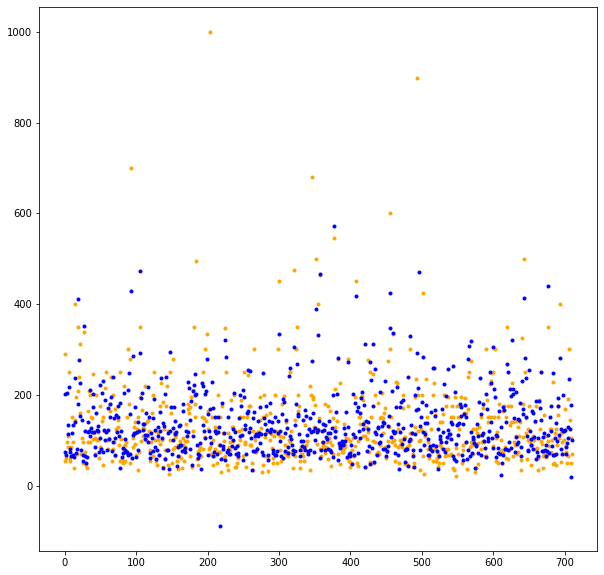

In [11]:
# analyse the predict result
data = np.concatenate([y_test, pred], axis=1)
plt.figure(figsize=(10, 10))
# the actual values are in orange and the predicted values are in blue
plt.plot(data[:,0], marker='.', linestyle='', color='orange')
plt.plot(data[:,1], marker='.', linestyle='', color='blue')

<Figure size 720x720 with 0 Axes>

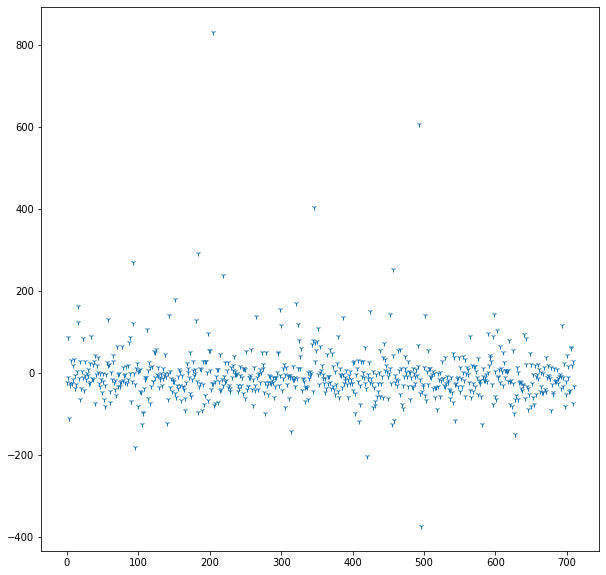

In [12]:
# and plot the predict error: y_test - pred
plt.figure(figsize=(10,10))
plt.plot(data[:,0] - data[:,1], marker='1', linestyle='')